Web Scraper

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the main Pokemon list page
base_url = "https://pokemondb.net"
list_url = f"{base_url}/pokedex/national"

response = requests.get(list_url)
soup = BeautifulSoup(response.text, 'html.parser')

pokemon_links = soup.select('.infocard a.ent-name')
pokemon_data = []

# Extract data
for link in pokemon_links:
    name = link.text
    url = f"{base_url}{link['href']}"

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    entries_table = soup.find('h2', string='Pokédex entries')
    if entries_table:
        entries_table = entries_table.find_next('table')
        entries = [entry.text.strip() for entry in entries_table.select('td.cell-med-text')]
    else:
        entries = []
        print(f"No Pokédex entries found for {name}")

    # Find the stats table
    stats_table = soup.find('h2', string='Base stats').find_next('table')
    stats = {}
    for row in stats_table.select('tbody > tr'):
        stat_name = row.find('th').text.strip()
        stat_value = row.find('td', class_='cell-num').text.strip()
        stats[stat_name] = stat_value

    for entry in entries:
        pokemon_data.append({
            'entry': entry,
            'hp': stats['HP'],
            'attack': stats['Attack'],
            'defense': stats['Defense'],
            'sp_atk': stats['Sp. Atk'],
            'sp_def': stats['Sp. Def'],
            'speed': stats['Speed'],
        })

# Save to CSV
df = pd.DataFrame(pokemon_data)
df.to_csv('pokemon_entries_stats.csv', index=False)

No Pokédex entries found for Walking Wake
No Pokédex entries found for Iron Leaves
No Pokédex entries found for Dipplin
No Pokédex entries found for Poltchageist
No Pokédex entries found for Sinistcha
No Pokédex entries found for Okidogi
No Pokédex entries found for Munkidori
No Pokédex entries found for Fezandipiti
No Pokédex entries found for Ogerpon
No Pokédex entries found for Archaludon
No Pokédex entries found for Hydrapple
No Pokédex entries found for Gouging Fire
No Pokédex entries found for Raging Bolt
No Pokédex entries found for Iron Boulder
No Pokédex entries found for Iron Crown
No Pokédex entries found for Terapagos
No Pokédex entries found for Pecharunt


Randomize the order of the csv file to reduce bias


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('pokemon_entries_stats.csv')

randomized_df = df.sample(frac=1, random_state=42)

randomized_df.to_csv('pokemon_entries_stats_randomized.csv', index=False)

Peek at the data

In [3]:
# Load the dataset
data_path = 'pokemon_entries_stats_randomized.csv'
data = pd.read_csv(data_path)

print(data.head())

                                               entry   hp  attack  defense  \
0  Its healthy appetite leads to visible growth s...   70      55       75   
1  The rich, fluffy fur that covers its body feel...  140      70       45   
2  It has eyes that can see through anything. It ...   80     120       79   
3  The fragrance of the garland on its head has a...   70      60       75   
4  An examination of its cells revealed the prese...   55      65       95   

   sp_atk  sp_def  speed  
0      45      65     60  
1      85      50     45  
2      95      79     70  
3     110      75     90  
4      95      45     85  


Preprocessing

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

data['processed_entries'] = data['entry'].apply(preprocess_text)
stats = data[['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed']]

stats_normalized = (stats - stats.mean()) / stats.std()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Split data

In [5]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
train, temp = train_test_split(data, test_size=0.2, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

# Tokenize and pad sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['processed_entries'])

train_sequences = tokenizer.texts_to_sequences(train['processed_entries'])
valid_sequences = tokenizer.texts_to_sequences(valid['processed_entries'])
test_sequences = tokenizer.texts_to_sequences(test['processed_entries'])

train_padded = pad_sequences(train_sequences, padding='post', maxlen=100)
valid_padded = pad_sequences(valid_sequences, padding='post', maxlen=100)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=100)

# Extract normalized stats for training and validation
train_stats = stats_normalized.loc[train.index].values
valid_stats = stats_normalized.loc[valid.index].values


Build Model

In [41]:
import tensorflow as tf

# RNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 32, input_length=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6)  # One output for each stat
])

# Compile
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])

# Train
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_padded, train_stats, epochs=100, validation_data=(valid_padded, valid_stats), callbacks=[early_stopping])

Epoch 1/100
296/296 [==============================] - 18s 40ms/step - loss: 0.7262 - mean_squared_error: 0.9183 - val_loss: 0.6516 - val_mean_squared_error: 0.7762
Epoch 2/100
296/296 [==============================] - 6s 21ms/step - loss: 0.5905 - mean_squared_error: 0.6847 - val_loss: 0.5980 - val_mean_squared_error: 0.6884
Epoch 3/100
296/296 [==============================] - 6s 20ms/step - loss: 0.5265 - mean_squared_error: 0.5880 - val_loss: 0.5604 - val_mean_squared_error: 0.6274
Epoch 4/100
296/296 [==============================] - 6s 19ms/step - loss: 0.4720 - mean_squared_error: 0.5002 - val_loss: 0.5322 - val_mean_squared_error: 0.5881
Epoch 5/100
296/296 [==============================] - 6s 19ms/step - loss: 0.4255 - mean_squared_error: 0.4270 - val_loss: 0.5139 - val_mean_squared_error: 0.5614
Epoch 6/100
296/296 [==============================] - 6s 19ms/step - loss: 0.3917 - mean_squared_error: 0.3749 - val_loss: 0.4964 - val_mean_squared_error: 0.5233
Epoch 7/100
296

Loss curves

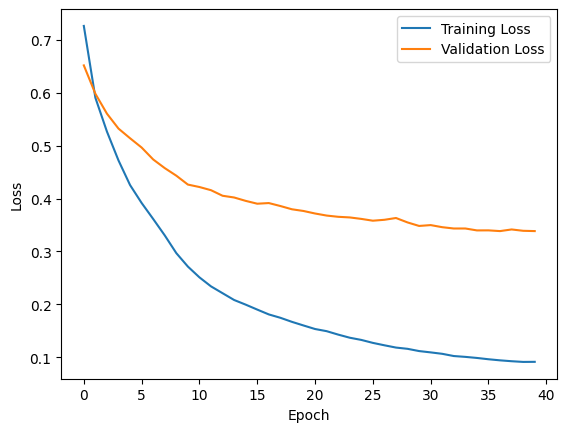

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate Model

In [43]:
test_loss, test_mae = model.evaluate(test_padded, stats_normalized.loc[test.index].values)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

37/37 [==============================] - 0s 8ms/step - loss: 0.3539 - mean_squared_error: 0.3759
Test Loss: 0.3539, Test MAE: 0.3759


Peek at Predictions

In [45]:
num_samples = 5
sample_indices = np.random.choice(len(test), num_samples, replace=False)

for idx in sample_indices:
    entry = test.iloc[idx]['entry']
    true_stats = stats.iloc[test.index[idx]]
    predicted_stats_normalized = model.predict(np.expand_dims(test_padded[idx], axis=0))
    predicted_stats_normalized = predicted_stats_normalized.reshape(-1)

    # Denormalize the predicted stats
    predicted_stats = np.round(predicted_stats_normalized * stats.std().values + stats.mean().values)

    print(f"Pokédex Entry: {entry}")
    print(f"True Stats: {true_stats.values}")
    print(f"Predicted Stats: {predicted_stats}")
    print("---")

1/1 [==============================] - 0s 28ms/step
Pokédex Entry: Its fine fur feels sublime to the touch. It can expand its body by inhaling air.
True Stats: [140  70  45  85  50  45]
Predicted Stats: [140.  67.  39.  84.  47.  40.]
---
1/1 [==============================] - 0s 24ms/step
Pokédex Entry: When it moves, it leaves only a blur. If it hides in grass, its protective coloration makes it invisible.
True Stats: [ 70 110  80  55  80 105]
Predicted Stats: [ 55.  88.  67.  39.  67. 100.]
---
1/1 [==============================] - 0s 24ms/step
Pokédex Entry: HERACROSS has sharp claws on its feet. These are planted firmly into the ground or the bark of a tree, giving the POKéMON a secure and solid footing to forcefully fling away foes with its proud horn.
True Stats: [ 80 125  75  40  95  85]
Predicted Stats: [ 78. 126.  71.  39.  92.  85.]
---
1/1 [==============================] - 0s 24ms/step
Pokédex Entry: This Pokémon was created using the cutting-edge science of 20 years ago,

Test With User Input

In [47]:
# Get user input for testing
while True:
    user_input = input("Enter a fake Pokédex entry (or 'quit' to exit): ")
    if user_input.lower() == 'quit':
        break

    user_input_processed = preprocess_text(user_input)
    user_input_sequence = tokenizer.texts_to_sequences([user_input_processed])
    user_input_padded = pad_sequences(user_input_sequence, padding='post', maxlen=100)

    # Make predictions on the user input
    user_input_predicted_normalized = model.predict(user_input_padded)
    user_input_predicted_normalized = user_input_predicted_normalized.reshape(-1)

    user_input_predicted = np.round(user_input_predicted_normalized * stats.std().values + stats.mean().values)

    print("Predicted Stats:")
    print("HP:", user_input_predicted[0])
    print("Attack:", user_input_predicted[1])
    print("Defense:", user_input_predicted[2])
    print("Special Attack:", user_input_predicted[3])
    print("Special Defense:", user_input_predicted[4])
    print("Speed:", user_input_predicted[5])
    print("---")

Enter a fake Pokédex entry (or 'quit' to exit): For some time after its birth, it uses the nutrients that are packed into the seed on its back in order to grow. The flame on its tail shows the strength of its life-force. If Charmander is weak, the flame also burns weakly. After birth, its back swells and hardens into a shell. It sprays a potent foam from its mouth.  
1/1 [==============================] - 0s 27ms/step
Predicted Stats:
HP: 30.0
Attack: 33.0
Defense: 53.0
Special Attack: 43.0
Special Defense: 70.0
Speed: 31.0
---
Enter a fake Pokédex entry (or 'quit' to exit): Junior is the overlord of the world. He eats, and eats, and never stops eating.
1/1 [==============================] - 0s 28ms/step
Predicted Stats:
HP: 87.0
Attack: 69.0
Defense: 69.0
Special Attack: 51.0
Special Defense: 68.0
Speed: 65.0
---
Enter a fake Pokédex entry (or 'quit' to exit): This cat creature can consume up to three hundred pounds of food per hour. When not eating, it sleeps until it can eat again. 

KeyboardInterrupt: Interrupted by user